In [1]:
from visual_transformer import *

In [2]:
device = torch.device('cuda:0')

In [5]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1070


In [3]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

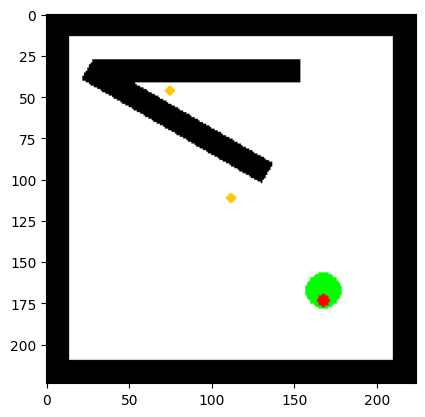

In [6]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [7]:
brain = DefaultAgentBrain().to(device)

In [8]:
brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorial1_v3_batch95000.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [9]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [10]:
vocab_size = 10000
# tokenizer.save_model(".", "tokenizer/eng_sentences_tokenizer_vc10000")
tokenizer = ByteLevelBPETokenizer(
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-vocab.json",
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-merges.txt",
)   
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)   
tokenizer.enable_truncation(max_length=32)
tokenizer.enable_padding()

In [11]:
task1_prompts = [ \
    "Imagine the line from the agent to the nearest gold.", \
    "What's the straight path from the agent to the gold?", \
    "Please draw the straight line to the gold from the agent.", \
    "How would you move from the agent to the gold?", \
    "What's a direct path from the agent to the gold?", \
    "From the agent to the nearest coin, please draw a path." ]

In [12]:
task1_text_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task1_prompts)]).contiguous().to(device)

In [13]:
# output format: image in, image out, text context
# no output text for now

def task1_img_sample(num_sample=40):
    img_in = torch.zeros(num_sample, 224, 224, 3)
    img_out = torch.zeros(num_sample, 224, 224, 3)
    for i in range(num_sample):
        bare_settings = G.random_bare_settings(gameSize=224, max_agent_offset=0.5)
        G2 = discreteGame(bare_settings)
        img_in[i] = torch.tensor(G2.getData())
        G2.bare_draw_arrow_at_gold()
        img_out[i] = torch.tensor(G2.getData())
    img_in = torch.permute(img_in, (0, 3, 1, 2)).contiguous().to(device)
    img_out = torch.permute(img_out, (0, 3, 1, 2)).contiguous().to(device)
    num_texts = task1_text_tensor.size()[0]
    text_inds = torch.randint(0, num_texts, size=(num_sample,), device=device)
    texts = task1_text_tensor[text_inds]
    return img_in, img_out, texts

In [14]:
brain.eval()

DefaultAgentBrain(
  (img_enc): ImageTransformerEncoder(
    (embed): Sequential(
      (0): PatchEmbedding(
        (linear_project): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (1): PositionalEncoding_2D()
      (2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (pe): PositionalEncoding_2D()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (

In [15]:
brain.training

False

In [16]:
# Let's test old recall first, a la ImagePretraining

In [17]:
criterion = nn.MSELoss()

In [18]:
img_set = G.random_full_image_set(restrict_angles=True)
img_tensor = torch.permute(torch.FloatTensor(img_set).to(device), (0, 3, 1, 2))
batch_size = img_tensor.size()[0]
text_context = torch.randn((batch_size, 32, 768), device=device) # easier for pretraining to use randn
recon = brain.img_autoencoder(img_tensor, text_context)
loss = criterion(recon, img_tensor)

/home/atbolsh/anaconda3/envs/llava-florence/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [19]:
loss.item()

0.03573223948478699

In [20]:
# bad, bad news

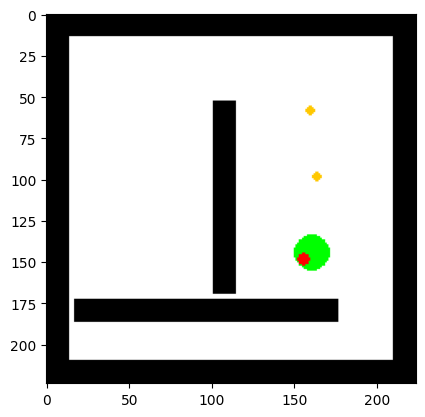

In [21]:
quick_display(img_tensor[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34251368..1.3604484].


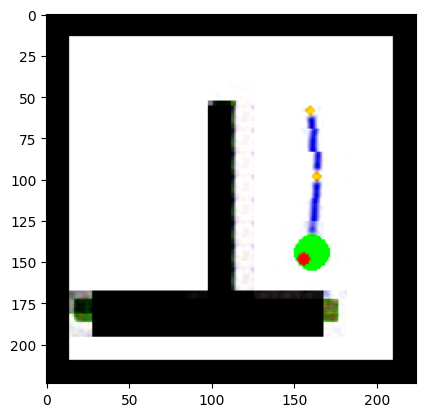

In [22]:
# ugly, but honestly kind of a cool associative combination
quick_display(recon[0])

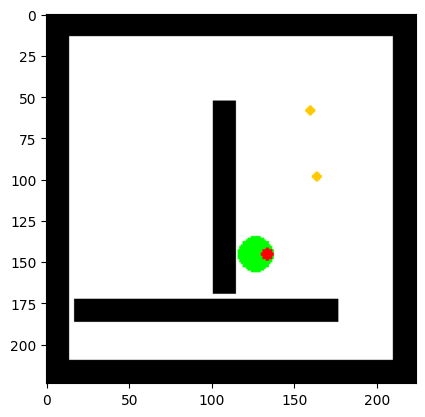

In [23]:
quick_display(img_tensor[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36703104..1.2991961].


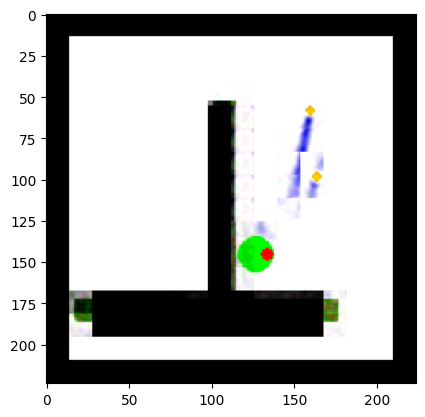

In [24]:
quick_display(recon[1])

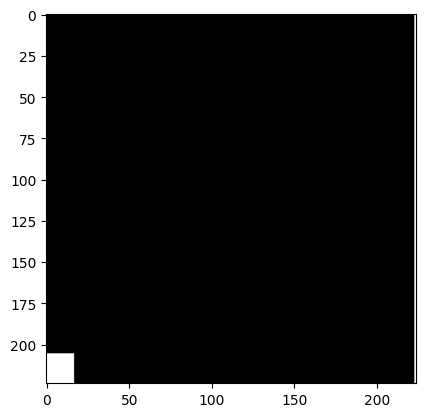

In [25]:
quick_display(img_tensor[35])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047272466..1.022711].


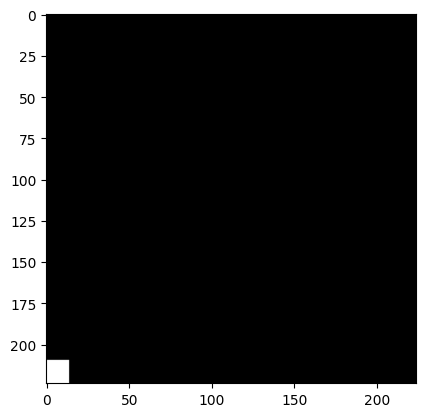

In [26]:
quick_display(recon[35])

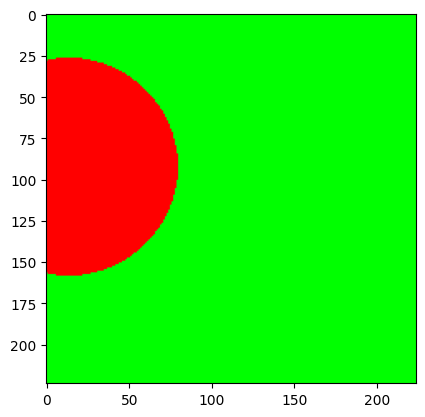

In [27]:
quick_display(img_tensor[32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7492149..0.8635793].


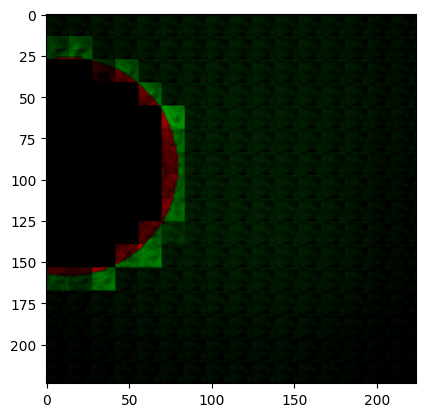

In [28]:
quick_display(recon[32])

In [29]:
# Goddamn nightmare fuel
# Ok, now I know where this stands.
# I know that I will have good recall with tasks seen in the FirstTutorial, and bad performance on other tasks